# Graph Generation Rewrite

In [1]:
import os
import pickle as pkl
import pyrosetta as pr
from pyrosetta import *
from pyrosetta.rosetta.core.scoring import *
from pyrosetta.rosetta.core.pose import get_chain_from_chain_id, center_of_mass
from pyrosetta.rosetta.core.select.residue_selector import ChainSelector, \
ResidueIndexSelector, NeighborhoodResidueSelector
from pyrosetta.rosetta.core.select import get_residues_from_subset
import logging
import pandas as pd
import numpy as np
pr.init()


PyRosetta-4 2019 [Rosetta PyRosetta4.conda.mac.python37.Release 2019.30+release.0da57b43256586e78d19865fc7cdcf9ccfb99d66 2019-07-21T15:08:17] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.conda.mac.python37.Release r228 2019.30+release.0da57b43256 0da57b43256586e78d19865fc7cdcf9ccfb99d66 http://www.pyrosetta.org 2019-07-21T15:08:17
core.init: command: PyRosetta -ex1 -ex2aro -database /Users/cplu/anaconda3/envs/pyrosetta4/lib/python3.7/site-packages/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=1560523888 seed_offset=0 real_seed=1560523888
core.init.random: RandomGenerator:init: Normal mode, seed=1560523888 RG_type=mt19937


In [2]:
#preset
sfxn = get_fa_scorefxn()
classifier_path = "classifications/"
data_path = "../data" 
pdb_path = "crystal_structures"


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard res

In [ ]:
def parse_args():
    parser.add_argument("-o", "--output", help="Output name")
    parser.add_argument("-pr_path", "--protease_path", default = "", help="Path to silent pose directory for protease")
    parser.add_argument("-class", "--classification_file", default = "", help="Name of txt for sequences to use, must be in folder")
    parser.add_argument("-index_p1", "--index_p1", default = 7, help="Index of p1 in the pdb, starting from 1.")
    parser.add_argument("-prot", "--protease", default="HCV.pdb", help="Protease pdb name.")
    parser.add_argument("-d","--select_distance",default=10, help="Distance for NeighborSelector")
    return parser.parse_args()
    # parser.add_argument("-si", "--size_interface", help="|Interface|", type = int)
    # parser.add_argument("-is", "--interface_selector", help="Way Interface Is Selected, either k_nearest or residue_wise currently")
    # parser.add_argument("-unsafe", "--unsafe", help="Overwrite datasets", action='store_true')
    # parser.add_argument("-params", "--params", default = "", help= "parameters dict for the graphs")

In [ ]:
class_file = args.class
output = args.output
pr_path = args.protease_path
index_p1 = args.index_p1
protease = args.protease


In [5]:
def get_logger(logpath, filepath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
    logger.info(filepath)
    with open(filepath, "r") as f:
        logger.info(f.read())

    for f in package_files:
        logger.info(f)
        with open(f, "r") as package_f:
            logger.info(package_f.read())

    return logger

In [ ]:
logger = get_logger(logpath=os.path.join(data_path, 'logs'), filepath=os.path.abspath(__file__))

In [ ]:
logger.info(params)

In [10]:
class_file = "sample.txt"

In [13]:
# Read in labels and sequences
try:
    df = pd.read_csv(os.path.join(classifier_path, class_file), sep = "\t")
    labels = list(df["Result"])
    sequences = list(df["Sequence"])
except:
    raise ValueError("Path either invalid to classsifications or not properly formatted. \
Please check template experimental_binary_classifications.txt")

In [14]:
df

,Sequence,Result
0,AYYYEPC.ASHL,CLEAVED


In [3]:
def get_silent_file(sequence, path_to_silent_files):
    """This just returns an absolute path to the silent file (windows specific possibly) false if not found"""
    silent_file = None
    for silent in os.listdir(path_to_silent_files):
        correct = True
        for counter, char in enumerate(silent):
            if char != sequence[counter] and char != "_":
                correct = False
                break
        if correct:
            silent_file = silent
            break
    if silent_file == None:
        print("Silent dir for {} not found in {}!".format(sequence, path_to_silent_files))
        return False
    silent_dir = os.path.join(path_to_silent_files, silent_file)
    silent_file_path = os.path.join(silent_dir, silent_file)
    
    if os.path.exists(silent_file_path):
        return silent_file_path
    else:
        print("Silent file for {} not found {}!".format(sequence, silent_file_path))
        return False

In [28]:
silent = get_silent_file("AYAKEPC.ASHL","silent")

In [29]:
silent

'silent/AYAK__C.ASHL/AYAK__C.ASHL'

In [5]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [4]:
def generate_dummy_silent(sequence, path_to_silent_files):
    silent_file = get_silent_file(sequence, path_to_silent_files)
    if not silent_file:
            return "Error: No Silent"
    with open(silent_file) as f:
        lineList = f.readlines()
    tag_ending = "substrate.{}".format(sequence)
    found, done = (False, False)
    ind, start, end, last_score = (0,0,0,0)
    while ind < len(lineList) and not done:
        x = lineList[ind]
        if "SCORE" in x:
            last_score = ind
        if not found and "ANNOTATED_SEQUENCE: " in x and tag_ending in x:
            start = last_score
            found = True
        elif found and "ANNOTATED_SEQUENCE: " in x:
            end = last_score
            done = True
        ind += 1
    if not found:
        print("The requested sequence {} was not found in the silent file {} (Parsing Error)".format(sequence, silent_file))
        raise ValueError("The requested sequence {} was not found in the silent file {} (Parsing Error)".format(sequence, silent_file))
    if not done:
        end = len(lineList)
    
    filename = sequence + str(np.random.randint(10000, 100000))
    path_bin = os.path.join(os.getcwd(), "bin")
    makedirs(path_bin)
    filename = os.path.join(path_bin, filename)
    with open(filename, "w") as f:
        # add header
        for i in range(3):
            f.write(lineList[i])
        # add binary information
        for i in range(start, end):
            f.write(lineList[i])
    return filename

In [6]:
filename = generate_dummy_silent("AYYYEPC.ASHL","silent")

In [8]:
filename

'/Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL58135'

In [7]:
for pose in poses_from_silent(filename):
    ret = pose

core.io.silent.SilentFileData: Reading all structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL58135
core.io.silent.SilentFileData: Finished reading 1 structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL58135


In [43]:
ret

In [9]:
def get_pose_from_pdb(sequence, path):
    for pdb in os.listdir(path):
        if pdb == sequence:
            ret = pose_from_pdb(os.path.join(path, pdb))
    return ret

In [10]:
def get_pose(sequence, path, is_silent = True):
    if is_silent == True:
        try:
            filename = generate_dummy_silent(sequence, path)
            for pose in poses_from_silent(filename):
                ret = pose
            os.remove(filename)
            return ret
        except:
            return "Error: Invalid Silent"        
    else:
        ret = get_pose_from_pdb(sequence) # need to modify

In [11]:
pose = get_pose("AYYYEPC.ASHL","silent")

core.io.silent.SilentFileData: Reading all structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL75824
core.io.silent.SilentFileData: Finished reading 1 structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL75824


In [63]:
pose.dump_pdb("AYYYEPC.ASHL.pdb")

True

In [12]:
def index_substrate(pose):
    """Takes a pose and returns the indices of the substrate."""
    # get substrate with built in selector
    num_chains = pose.num_chains()
    chain_name = get_chain_from_chain_id(num_chains, pose)
    sub_sel = ChainSelector(chain_name)
    v1 = sub_sel.apply(pose)
    substrate_indices = []
    for count,ele in enumerate(v1):
        if ele:
            substrate_indices.append(count + 1)
    return substrate_indices

In [13]:
substrate_ind = index_substrate(pose)

In [14]:
substrate_ind

[197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207]

In [15]:
index_p1 = "AYYYEPC.ASHL".index(".")
index_p1

7

In [16]:
def index_substrate_cut_site(pose, index_p1 = 7, upstream_buffer = 6, downstream_buffer = -1, protease = None):
    """This function takes the ROSETTA INDEX of the P1 residue for a substrate within its chain, a pose, and
    the number of upstream and downstream residues to model, and returns the indices of the substrate. If the
    buffer actually goes OOB of the substrate, a None type for that ind is instead returned for 0 pad modelling"""
    ind_sub = index_substrate(pose)
    ind_active = []
    for i in range(-upstream_buffer, downstream_buffer):
        index_interest = i + index_p1
        if index_interest < 0 or index_interest >= len(ind_sub):
            ind_active.append(None)
        else:
            ind_active.append(ind_sub[index_interest])
    return ind_active

In [17]:
#try
cutsite_ind = index_substrate_cut_site(pose)
cutsite_ind

[198, 199, 200, 201, 202]

In [18]:
def selector_to_list(pose, selector):
    """
    Produces a list of residues from a pose identified by a given selector
    """

    return list(get_residues_from_subset(selector.apply(pose)))

In [19]:
def index_interface(pose,
                    active_site,
                    substrate_indices,
                    d=10):
    """This function takes a pose and a number of interface/substrate to consider and returns interface indices. The
    value k and pose are not used..."""
    
    # Selection for neighbor residues
    focus_res = ','.join([str(j) for j in substrate_indices])
    focus_selector = ResidueIndexSelector(focus_res)

    interface = NeighborhoodResidueSelector()
    interface.set_focus_selector(focus_selector)
    interface.set_distance(d)
    interface.set_include_focus_in_subset(False)
    interface_indices = selector_to_list(pose, interface)
    interface_indices.sort()
            
    return interface_indices

In [79]:
# try
index_p1 = 7

In [91]:
sfxn.score(pose)

basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /Users/cplu/anaconda3/envs/pyrosetta4/lib/python3.7/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/Users/cplu/anaconda3/envs/pyrosetta4/lib/python3.7/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.302067 seconds to load from binary


-483.2861533494107

In [20]:
hcv_pose = pose_from_pdb(os.path.join(pdb_path, "HCV.pdb"))
sfxn.score(hcv_pose)
interface_ind = index_interface(hcv_pose, cutsite_ind, substrate_ind, 10)

core.import_pose.import_pose: File 'crystal_structures/HCV.pdb' automatically determined to be of type PDB
basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /Users/cplu/anaconda3/envs/pyrosetta4/lib/python3.7/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/Users/cplu/anaconda3/envs/pyrosetta4/lib/python3.7/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.321671 seconds to load from binary


In [103]:
len(interface_ind)

44

In [23]:
def get_ind_from_protease(protease_name, pdb_path, index_p1, dis, sfxn):
    # load default pose as original
    pose = pose_from_pdb(os.path.join(pdb_path, protease_name))
    sfxn.score(pose)
    substrate_ind = index_substrate(pose) #the whole substrate
    cutsite_ind = index_substrate_cut_site(pose, index_p1) #p2-p6 on the substrate
    interface_ind = index_interface(pose, cutsite_ind, substrate_ind, dis)
    return cutsite_ind, interface_ind

In [24]:
#try
cutsite_ind, interface_ind = get_ind_from_protease("HCV.pdb", pdb_path, index_p1, 10, sfxn)


core.import_pose.import_pose: File 'crystal_structures/HCV.pdb' automatically determined to be of type PDB


In [130]:
','.join([str(u) for u in cutsite_ind])

'198,199,200,201,202'

In [109]:
pose.sequence()

'GSVVIVGRIILSGRGGPITAYAQQTRGLLGCIITSLTGRDKNQVEGEVQIVSTAAQTFLATCINGVCWTVYHGAGTRTIASPKGPVIQMYTNVDQDLVGWPASQGTRSLTPCTCGSSDLYLVTRHADVIPVRRRGDSRGSLLSPRPISYLKGSSGGPLLCPAGHAVGIFRAAVCTRGVAKAVDFIPVENLETTMRSAYYYEPCASHL'

In [108]:
print(center_of_mass(pose, 1, len(pose.sequence())))

      22.51380220451573      -23.18137728952420       40.13473036273557


In [116]:
class protein_graph:
    """This class is going to hold a graphical representation of a protein. It can be generated from two sources:
    a pose object, or the file path of a pdb. Since we are attempting to model a substrate/protein complex,
    the substrate and interface indices are ROSETTA(starting at 1) based indexes. When specified, these indices are
    the indices that are used as nodes. When not supplied, all indices are used. It is assumed that:
    
    The substrate's indices are the last in the pdb/pose
    When supplied interface and substrate are non-zero length
    The intersection of substrate and interface indices is empty
    Only canonical amino acids are not supported

    Possible Values:
    energy_terms = [fa_intra_sol_xover4, fa_intra_rep, rama_prepro, omega, p_aa_pp, fa_dun, ref]
    energy_edge_terms = [pro_close, fa_atr, fa_rep, fa_sol, fa_elec, lk_ball_wtd]"""
    
    def __init__ (self, substrate_indices = None,
                  interface_indices = None,
                  pdb_file_path = None,
                  pose = None,
                  params = dict(),
                  sfxn = None):

        # assure user provided a source
        if pdb_file_path == None and pose == None:
            raise PathNotDeclaredError("No pose or pdb path provided")
        
        # make pose from pdb
        if pdb_file_path != None:
            try:
                cleanATOM(pdb_file_path)##### Need to fix this #####
                pose = pose_from_pdb(pdb_file_path)
            except:
                raise PathNotDeclaredError("Failed to generate pose, file path invalid or other issue")
        
        # if substrate or interface indices are given we will make vertice_arr specially tailored
        ls = substrate_indices + interface_indices
        vertice_arr = np.array(ls)
        interface_indices = np.array(interface_indices)
        substrate_indices = np.array(substrate_indices)
        
        # Get All Node Features
        if params["amino_acids"]: num_amino = 20
        else: num_amino = 0
        num_dim_sine = params["sinusoidal_encoding"]
        energy_terms = len(params["energy_terms"])
        if params["coordinates"]: num_coord = 3
        else: num_coord = 0
        
        # Make and Apply Score Function
        if sfxn == None: sfxn = get_fa_scorefxn()
        sfxn(pose)
        energies = pose.energies()
        
        # Determine N (number of residues)
        N = len(vertice_arr)
        
        # Determine F (number of node features)
        F = sum([num_amino, num_dim_sine, energy_terms, num_coord])
        if params["substrate_boolean"]: F += 1
        
        # Initialize V (Feature Tensor NxF)
        self.V = np.zeros(shape = (N, F))
        
        # Determine M (number of edge features)
        M = 0
#         if params["distance"]: M += 1
        M += len(params["energy_edge_terms"])
        if params["interface_edge"]: M += 1
        if params["covalent_edge"]: M += 1
        if params["hbond"]: M += 1
        # initialize A (Multiple Adj. Mat. NxNxM)
        self.A = np.zeros(shape = (N, N, M))
        counter_F = 0
        counter_M = 0

        # One Hot Vectors for Amino Acid Type
        if params["amino_acids"]:
            all_amino_acids = "ACDEFGHIKLMNPQRSTVWY"
            seq = pose.sequence()        
            # use the native ordering to generate features
            for i in range(len(vertice_arr)):
                i_ind = vertice_arr[i]
                if i_ind != None:
                    res = seq[i_ind - 1]
                    j = all_amino_acids.find(res)
                    self.V[i][j] = 1
            counter_F += 20
        
        # Sinusoidal Positional Encoding
        if num_dim_sine != 0:
            if not substrate_indices.any() and not interface_indices.any():
                n_position = N
                position_enc = np.array([
                    [pos / np.power(10000, 2*i/num_dim_sine) for i in range(num_dim_sine)]
                    if pos != 0 else np.zeros(num_dim_sine) for pos in range(n_position)])
                position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
                position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
                self.V[0:n_position,counter_F:(counter_F + num_dim_sine)] = position_enc
            elif substrate_indices.any() and interface_indices.any():
                # add substrates
                n_position = len(substrate_indices)
                position_enc = np.array([
                    [pos / np.power(10000, 2*i/num_dim_sine) for i in range(num_dim_sine)]
                    if pos != 0 else np.zeros(num_dim_sine) for pos in range(n_position)])
                position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
                position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
                
                for i in range(len(substrate_indices)):
                    if substrate_indices[i] != None:
                        self.V[i, counter_F:(counter_F + num_dim_sine)] = position_enc[i, :]
                # add interface
                n_position = len(pose.sequence()) - len(substrate_indices)
                position_enc = np.array([
                    [pos / np.power(10000, 2*i/num_dim_sine) for i in range(num_dim_sine)]
                    if pos != 0 else np.zeros(num_dim_sine) for pos in range(n_position)])
                position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
                position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
                for i in range(N - len(substrate_indices)):
                    if interface_indices[i] != None:
                        self.V[(len(substrate_indices) + i), counter_F:(counter_F + num_dim_sine)] = position_enc[i, :]
            else:
                # add substrates
                n_position = len(substrate_indices)
                position_enc = np.array([
                    [pos / np.power(10000, 2*i/num_dim_sine) for i in range(num_dim_sine)]
                    if pos != 0 else np.zeros(num_dim_sine) for pos in (substrate_indices - substrate_indices[0])])
                position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
                position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
                self.V[0:n_position,counter_F:(counter_F + num_dim_sine)] = position_enc
            counter_F += num_dim_sine

        # Single Body Energy Terms
        for counter, term in enumerate(params["energy_terms"], counter_F):
            for i in range(N):
                if vertice_arr[i] != None:
                    self.V[i, counter] = energies.residue_total_energies(vertice_arr[i])[term]
        counter_F += energy_terms

        if params["coordinates"]:
            for i in range(len(vertice_arr)):
                if vertice_arr[i] != None:
                    C_alpha_coord = to_numpy(pose.residue(vertice_arr[i]).xyz("CA"))
                    self.V[i, counter_F : (counter_F + 3)] = C_alpha_coord
            counter_F += 3
            print(self.V[i, counter_F : (counter_F + 3)])
        # New node feature
        """
        if params["new feature"]:
            self.V[:, counter_F] = whatever
            counter_F += 1
        """
        
        # Substrate boolean
        if params["substrate_boolean"]:
            self.V[0:len(substrate_indices),counter_F] = np.array([1 for x in range(len(substrate_indices))])

        # Total Two Body Energy and Energy Terms
        if len(params["energy_edge_terms"]) != 0:
            for i in range(len(vertice_arr)):
                for j in range(i, len(vertice_arr)):
                    if vertice_arr[i] != None and vertice_arr[j] != None:
                        if i != j:
                            rsd1 = pose.residue(vertice_arr[i])
                            rsd2 = pose.residue(vertice_arr[j])
                            emap = EMapVector()
                            sfxn.eval_ci_2b(rsd1, rsd2, pose, emap)
                            for counter, term in enumerate(params["energy_edge_terms"]):
                                self.A[i, j, counter_M + counter] = emap[term]
                                self.A[j, i, counter_M + counter] = emap[term]
            counter_M += len(params["energy_edge_terms"])

        # Hydrogen Bonding Energies
        if params["hbond"]:
            hbs=pose.get_hbonds()
            res_dict = dict()
            for res in vertice_arr:
                hbl = hbs.residue_hbonds(res)
                for hb in hbl:
                    residues = (hb.don_res(), hb.acc_res())
                    if residues[0] > residues[1]: residues = (hb.acc_res(), hb.don_res())
                    if residues[0] in vertice_arr and residues[1] in vertice_arr: res_dict[residues] = hb.energy()
            for residues in res_dict:
                for i in np.where(vertice_arr==residues[0])[0]:
                    for j in np.where(vertice_arr==residues[1])[0]:
                        self.A[i,j,counter_M] += self.A[i,j,counter_M] + res_dict[residues]
                        self.A[j,i,counter_M] += self.A[j,i,counter_M] + res_dict[residues]
            counter_M += 1

        # Protease - Substrate Interactions Boolean
        if params["interface_edge"]:
            self.A[0:len(substrate_indices), len(substrate_indices):len(vertice_arr), counter_M] = 1
            self.A[len(substrate_indices):len(vertice_arr), 0:len(substrate_indices), counter_M] = 1
            counter_M += 1

        # Covalent Bond Connection Boolean
        if params["covalent_edge"]:
            for i in range(len(vertice_arr) - 1):
                if vertice_arr[i + 1] - vertice_arr[i] == 1:
                    self.A[i, i + 1, counter_M] = 1
                    self.A[i + 1, i, counter_M] = 1
            counter_M += 1
        print(vertice_arr)

In [122]:
# Goes from a sequence to a graph representation.
def generate_graph(seq, pr_path, substrate_ind, interface_ind, params, sfxn):
    pose = get_pose(seq, pr_path)
    if type(pose) == type("string"):
        return pose
    g = protein_graph(pose = pose,
                       substrate_indices = cutsite_ind,
                       interface_indices = interface_ind,
                       sfxn = sfxn,
                       params = params)
    return g

In [124]:
gg =generate_graph("AYYYEPC.ASHL","silent",substrate_ind,interface_ind,params,sfxn)

core.io.silent.SilentFileData: Reading all structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL54063
core.io.silent.SilentFileData: Finished reading 1 structures from /Users/cplu/Downloads/Documents/RESEARCH/GCNN/protease-gcnn-pytorch/graph/bin/AYYYEPC.ASHL54063
[198 199 200 201 202  51  52  53  55  56  57  58  59  69  70  71  72  73
  74  75  96 123 124 138 147 148 149 150 151 152 153 154 155 156 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183]


In [117]:
params = {"amino_acids":True,
                "sinusoidal_encoding":2,
#                 "cosine_similarity":False,
                "coordinates": False,
                "substrate_boolean":True,
                "energy_terms":[fa_intra_sol_xover4, fa_intra_rep, rama_prepro, omega, p_aa_pp, fa_dun, ref],
                "energy_edge_terms":[fa_atr, fa_rep, fa_sol, fa_elec, lk_ball_wtd],
                "hbond": True,
                "interface_edge": True,
                "covalent_edge": True,
#                 "distance":True,
#                 "energy":True
         }

In [118]:
g = protein_graph(pose = pose,
                       substrate_indices = cutsite_ind,
                       interface_indices = interface_ind,
                       sfxn = sfxn,
                       params = params)

[198 199 200 201 202  51  52  53  55  56  57  58  59  69  70  71  72  73
  74  75  96 123 124 138 147 148 149 150 151 152 153 154 155 156 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183]


In [126]:
gg.V[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.24161177,  4.16952966, -0.49597924,
        0.02561926,  0.09068901,  3.8212185 ,  0.58223   ,  1.        ])

In [32]:
g.V.shape, g.A.shape

((49, 30), (49, 49, 10))

In [41]:
columns = ["aa1","aa2","aa3","aa4","aa5","aa6","aa7","aa8","aa9","aa10",
          "aa11","aa12","aa13","aa14","aa15","aa16","aa17","aa18","aa19","aa20",
          "sin1","sin2","fa_intra_sol_xover4", "fa_intra_rep", "rama_prepro", 
           "omega", "p_aa_pp", "fa_dun", "ref","is_substrate"]

In [42]:
df = pd.DataFrame(g.V, columns = columns)

In [49]:
df.iloc[0,19]

1.0

In [51]:
df.head()

,aa1,aa2,aa3,aa4,aa5,aa6,aa7,aa8,aa9,aa10,...,sin1,sin2,fa_intra_sol_xover4,fa_intra_rep,rama_prepro,omega,p_aa_pp,fa_dun,ref,is_substrate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.241612,4.169530,-0.495979,0.025619,0.090689,3.821219,0.58223,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.841471,1.0,0.268187,4.235788,0.959456,1.152130,-0.566650,2.408025,0.58223,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.909297,1.0,0.286675,4.379675,1.205627,-0.092665,0.053928,4.067401,0.58223,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.141120,1.0,0.297897,1.398956,1.115776,-0.055925,0.326248,4.119510,-2.72453,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.756802,1.0,0.116397,0.797717,0.684848,1.322425,-1.481414,0.895828,-1.64321,1.0


In [119]:
columns=["fa_atr", "fa_rep", "fa_sol", "fa_elec", "lk_ball_wtd", "hbond",
        "link_interface_substrate","is_covalent"]
df_edge = pd.DataFrame(g.A[1], columns = columns)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 2401.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([-0.5  , -0.475, -0.45 , -0.425, -0.4  , -0.375, -0.35 , -0.325,
        -0.3  , -0.275, -0.25 , -0.225, -0.2  , -0.175, -0.15 , -0.125,
        -0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,
         0.1  ,  0.125,  0.15 ,  0.175,  0.2  ,  0.225,  0.25 ,  0.275,
         0.3  ,  0.325,  0.35 ,  0.375,  0.4  ,  0.425,  0.45 ,  0.475,
         0.5  ]),
 <a list of 40 Patch objects>)

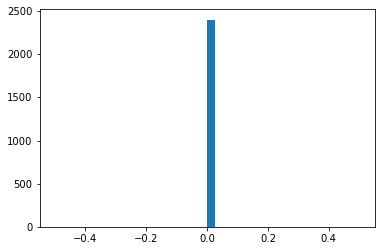

In [80]:
import matplotlib.pyplot as plt
plt.hist(g.A[:,:,5].flatten(),bins=40)

In [ ]:
#pro_close, hbond_sc = 0?

In [68]:
sum(g.A[:,:,7].flatten()!=0)

66

In [69]:
np.where(g.A[:,:,7]!=0)

(array([ 1,  3,  3,  5,  6,  7,  7,  7,  8,  9,  9,  9, 10, 11, 12, 12, 13,
        13, 14, 14, 14, 15, 15, 16, 16, 17, 17, 18, 19, 20, 20, 20, 22, 22,
        22, 23, 24, 24, 27, 28, 28, 29, 30, 30, 30, 31, 32, 33, 33, 34, 34,
        35, 35, 36, 37, 38, 38, 39, 40, 42, 43, 45, 46, 48, 48, 48]),
 array([39, 28, 37, 11,  7,  6,  8,  9,  7,  7, 16, 17, 22,  5, 13, 31, 12,
        14, 13, 17, 18, 19, 20,  9, 20,  9, 14, 14, 15, 15, 16, 35, 10, 29,
        30, 48, 28, 42, 30,  3, 24, 22, 22, 27, 33, 12, 34, 30, 34, 32, 33,
        20, 48, 48,  3, 45, 46,  1, 43, 24, 40, 38, 38, 23, 35, 36]))

In [81]:
hbs=pose.get_hbonds()


In [95]:
vertice_arr = "198 199 200 201 202  51  52  53  55  56  57  58  59  69  70  71  72  73  74  75  96 123 124 138 147 148 149 150 151 152 153 154 155 156 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183".split(" ")
while '' in vertice_arr:
    vertice_arr.pop(vertice_arr.index(''))
vertice_arr = [int(x) for x in vertice_arr]


In [110]:
for hb in hbs.residue_hbonds(199):
    print(hb)
    print(hb.don_res(),hb.acc_res())

9 don: protein backbone 174 7 acc: protein backbone 199 4 -1.38681 1

174 199


In [ ]:
def main(args):
    #preset
    pr.init()
    sfxn = get_fa_scorefxn()
    classifier_path = "classifications/"
    data_path = "../data" 
    pdb_path = "crystal_structures"
    
    class_file = args.class #list of samples
    output = args.output 
    pr_path = args.protease_path
    index_p1 = args.index_p1
    protease = args.protease
    dis = args.select_sequence
    
    logger = get_logger(logpath=os.path.join(data_path, 'logs'), filepath=os.path.abspath(__file__))
    
    params = {"amino_acids":True,
                "sinusoidal_encoding":2,
                "coordinates": False,
                "substrate_boolean":True,
                "energy_terms":[fa_intra_sol_xover4, fa_intra_rep, rama_prepro, omega, p_aa_pp, fa_dun, ref],
                "energy_edge_terms":[fa_atr, fa_rep, fa_sol, fa_elec, lk_ball_wtd],
                "hbond": True,
                "interface_edge": True,
                "covalent_edge": True,}
    logger.info("Features Info: {}".format(params))
    
    cutsite_ind, interface_ind = get_ind_from_protease(args.protease, pdb_path, index_p1, d, sfxn)
    logger.info("Focus substrate indices are {}".format(','.join(cutsite_ind)))
    logger.info("Neighbor residues indices are {}".format(','.join(interface_ind)))
    
    # Read in labels and sequences
    try:
        df = pd.read_csv(os.path.join(classifier_path, class_file), sep = "\t")
        labels = list(df["Result"])
        sequences = list(df["Sequence"])
    except:
        raise ValueError("Path either invalid to classsifications or not properly formatted. \
    Please check template sample.txt")
    
    # get all graphs into a list
    missed_sequences = []
    error_sequences = []
    seq_final = []
    label_final = []
    graphs = []
    for i in range(len(sequences)):
        seq = sequences[i]
        graph = generate_graph(seq, pr_path, cutsite_ind, interface_ind)
        logger.info("Graph for {} has been generated successfully.".format(seq))
        if graph == "Error: No Silent":
            missed_sequences.append(seq)
        elif graph == "Error: Invalid Silent":
            error_sequences.append(seq)
        else:
            seq_final.append(seq)
            graphs.append(graph)
            label_final.append(labels[i])
    
    logger.info("There were {} poses which loaded".format(len(graphs)))
    logger.info("There were {} poses missing due to silent files.".format(len(missed_sequences)))
    logger.info("There were {} poses which failed to be loaded.".format(len(error_sequences)))
    
if __name__ == '__main__':
    args = parse_args()
    main(args)    

In [131]:
x = pkl.load(open(os.path.join(data_path, "ind.sample.x"),"rb"))
y = pkl.load(open(os.path.join(data_path, "ind.sample.y"),"rb"))
graph = pkl.load(open(os.path.join(data_path,"ind.sample.graph"),"rb"))
labelorder = pkl.load(open(os.path.join(data_path,"ind.sample.labelorder"),"rb"))
sequences = pkl.load(open(os.path.join(data_path,"ind.sample.sequences"),"rb"))